In [1]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create directories if they don't exist
label = 'Y'  # change for each letter
save_path = f"sign_dataset/{label}"
os.makedirs(save_path, exist_ok=True)

# Open webcam
cap = cv2.VideoCapture(0)
count = 0

while count < 50:
    ret, frame = cap.read()
    if not ret:
        continue
        
    # Draw ROI guide
    cv2.rectangle(frame, (100, 100), (300, 300), (0, 255, 0), 2)
    cv2.imshow("Capture", frame)
    
    key = cv2.waitKey(1)
    if key == ord('s'):  # Press 's' to save
        roi = frame[100:300, 100:300]  # 200x200 ROI
        
        # Preprocess the ROI
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi_resized = cv2.resize(roi_gray, (64, 64))  # Larger resolution
        
        # Apply edge detection to focus on hand shape
        roi_edges = cv2.Canny(roi_resized, 30, 200)
        
        # Save both preprocessed and original images
        img_path = os.path.join(save_path, f"{count}.jpg")
        cv2.imwrite(img_path, roi)
        
        edge_path = os.path.join(save_path, f"{count}_edge.jpg")
        cv2.imwrite(edge_path, roi_edges)
        
        print(f"Saved image {count}")
        count += 1
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Parameters
img_size = (64, 64)  # Larger size for more detail
batch_size = 32
color_mode = 'grayscale'  # Focus on shapes, not colors

# Load training data with augmentation
train_ds = train_datagen.flow_from_directory(
    "sign_dataset",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    color_mode=color_mode,
    seed=42
)

# Load validation data
val_ds = val_datagen.flow_from_directory(
    "sign_dataset",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    color_mode=color_mode,
    seed=42
)

# Store class names for later
class_names = list(train_ds.class_indices.keys())
print(f"Classes: {class_names}")

Found 1616 images belonging to 24 classes.
Found 404 images belonging to 24 classes.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Input shape: grayscale images
input_shape = (64, 64, 1)
num_classes = len(class_names)

# Create a more sophisticated model
model = models.Sequential([
    # Input layer
    layers.Input(shape=input_shape),
    
    # First convolution block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Second convolution block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third convolution block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile with a slightly lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary to check architecture
model.summary()

# Training callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]

# Train with more epochs but early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

# Save the model
model.save('sign_language_model.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,392,824 (9.13 MB)

 Trainable params: 2,391,416 (9.12 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/30


c:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.0980 - loss: 3.8593 - val_accuracy: 0.0594 - val_loss: 3.9446 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - accuracy: 0.2533 - loss: 2.5714 - val_accuracy: 0.0495 - val_loss: 5.8804 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.3840 - loss: 2.0756 - val_accuracy: 0.0396 - val_loss: 7.8866 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - accuracy: 0.4890 - loss: 1.6911 - val_accuracy: 0.0396 - val_loss: 8.2562 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 524ms/step - accuracy: 0.6304 - loss: 1.2282 - val_accuracy: 0.0396 - val_loss: 7.4576 - learning_rate: 2.0000e-04
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.6692 - loss: 1.1043 - val_accuracy: 0.0396 - val_loss: 6.7250 - learning_rate: 2.0000e-04


In [4]:
# Add this code to check model performance
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test accuracy: {test_acc:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.0522 - loss: 3.9028
Test accuracy: 0.06


Found 1616 images belonging to 24 classes.
Found 404 images belonging to 24 classes.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Number of classes: 24
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.1258 - loss: 3.2728 - val_accuracy: 0.5223 - val_loss: 1.7093 - learning_rate: 0.0010
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.4062 - loss: 1.9527 - val_accuracy: 0.7129 - val_loss: 1.1682 - learning_rate: 0.0010
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - accuracy: 0.5509 - loss: 1.5444 - val_accuracy: 0.7426 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.6083 - loss: 1.3056 - val_accuracy: 0.7896 - val_loss: 0.8154 - learning_rate: 0.0010
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.6582 - loss: 1.1640 - val_accuracy: 0.8045 - val_loss: 0.7463 - learning_rate: 0.001

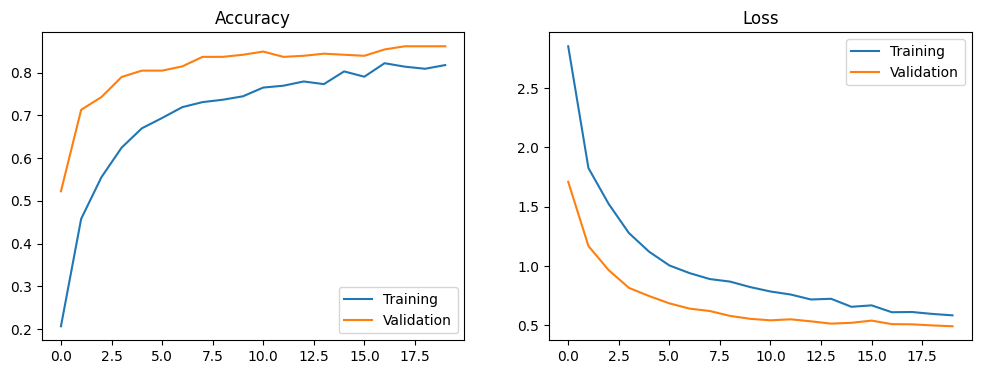

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Set up parameters
img_size = (96, 96)
batch_size = 32
num_classes = 22  # Make sure this matches your actual class count

# Set up data generators with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load data
train_ds = train_datagen.flow_from_directory(
    "sign_dataset",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_ds = val_datagen.flow_from_directory(
    "sign_dataset",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Print class names to confirm correct loading
class_names = list(train_ds.class_indices.keys())
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Create a base model from MobileNetV2
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test accuracy: {test_acc:.4f}")

# Save the model
model.save('sign_language_transfer_model.keras')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [6]:
import os

dataset_path = "sign_dataset"
classes = os.listdir(dataset_path)

# Print folder structure
print(f"Found {len(classes)} class folders:")
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        image_files = [f for f in os.listdir(cls_path) if f.endswith('.jpg') or f.endswith('.png')]
        print(f"- {cls}: {len(image_files)} images")

Found 24 class folders:
- A: 60 images
- B: 60 images
- C: 60 images
- D: 60 images
- E: 60 images
- F: 80 images
- G: 80 images
- H: 80 images
- I: 80 images
- K: 80 images
- L: 80 images
- M: 80 images
- N: 80 images
- O: 80 images
- P: 100 images
- Q: 100 images
- R: 100 images
- S: 100 images
- T: 100 images
- U: 100 images
- V: 100 images
- W: 100 images
- X: 100 images
- Y: 100 images


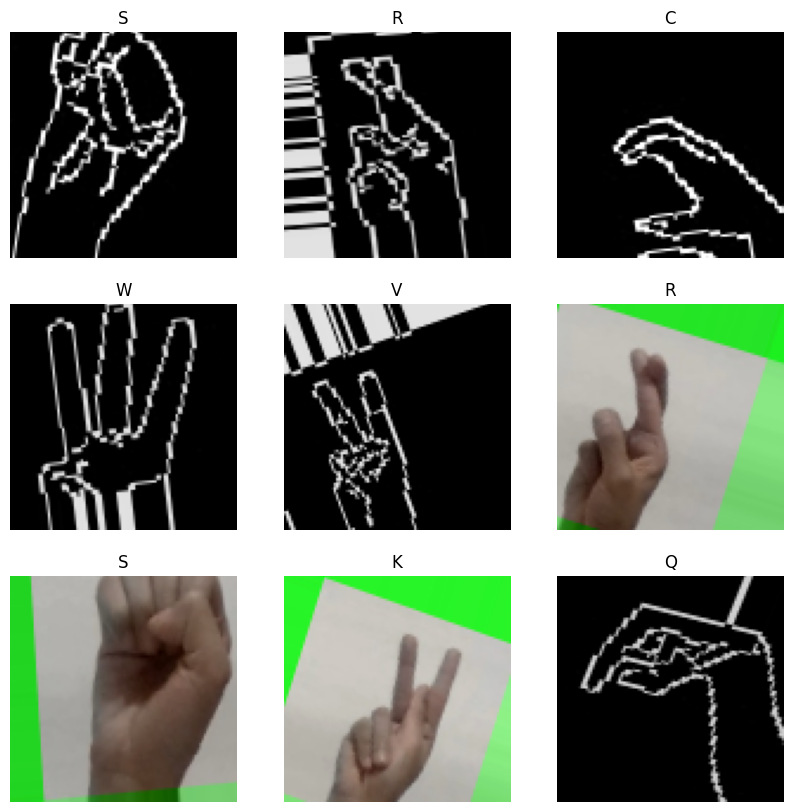

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images from a generator
def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        label = np.argmax(label_batch[i])
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()

# Get a batch from your data
images, labels = next(train_ds)
show_batch(images, labels, class_names)

In [8]:
import cv2
import numpy as np
import tensorflow as tf
from collections import Counter

# Load the trained model
model = tf.keras.models.load_model('sign_language_transfer_model.keras')

# Corrected class names - include all 24 classes
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 
               'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
               'V', 'W', 'X', 'Y']  # Now 24 total

# Webcam setup
cap = cv2.VideoCapture(0)

# Prediction history for smoothing
prediction_history = []
max_history = 7

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Draw region of interest
    cv2.rectangle(frame, (100, 100), (300, 300), (0, 255, 0), 2)
    roi = frame[100:300, 100:300]

    # Preprocess for model
    roi_resized = cv2.resize(roi, (96, 96))
    roi_normalized = roi_resized / 255.0
    roi_tensor = np.expand_dims(roi_normalized, axis=0)

    # Prediction
    prediction = model.predict(roi_tensor, verbose=0)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0][predicted_index]

    # Maintain history if confident
    if confidence > 0.3:
        prediction_history.append(predicted_index)
        if len(prediction_history) > max_history:
            prediction_history.pop(0)

    # Decide final letter from history
    if len(prediction_history) >= 3:
        most_common = Counter(prediction_history).most_common(1)[0][0]
        letter = class_names[most_common] if most_common < len(class_names) else '?'
    else:
        letter = class_names[predicted_index] if predicted_index < len(class_names) and confidence > 0.4 else '?'

    # Display predictions
    cv2.putText(frame, f"Prediction: {letter}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Confidence: {confidence:.2f}", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Sign Language Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
